# Connecting to the IBM Quantum Platform

Simulating is very useful, but often there is no realistic substitute for running circuits on real hardware. Mostly when the problem scales in the amount of qubits (limited to 20-25 on traditional hardware). Or when the physics of the hardware need to be characterised.

Luckily IBM provides access to hardware through their cloud platform. There is a free tier of 10 minutes of runtime per month. Connecting requires an API key and is quite simple to set up. How to set up communication to the IBM cloud account can be found here: [Set up your IBM Cloud account](https://quantum.cloud.ibm.com/docs/en/guides/cloud-setup).
You will have to set up payment options with a credit card to unlock functionality. However, the plan is pay-as-you-go, so when you only use the free options you shouldn't get charged. Upgrading can be done here: https://cloud.ibm.com/billing/payments

For this we will create a simple circuit that will build all 4 Bell states and measures them. First we will explore the circuits using QuTiP.


(The *SNOT* gate is used here instead of *H*, otherwise it will give issues later when exporting the circuit as qasm, they are equivalent from the perspective of `qutip.qip.Gate`)

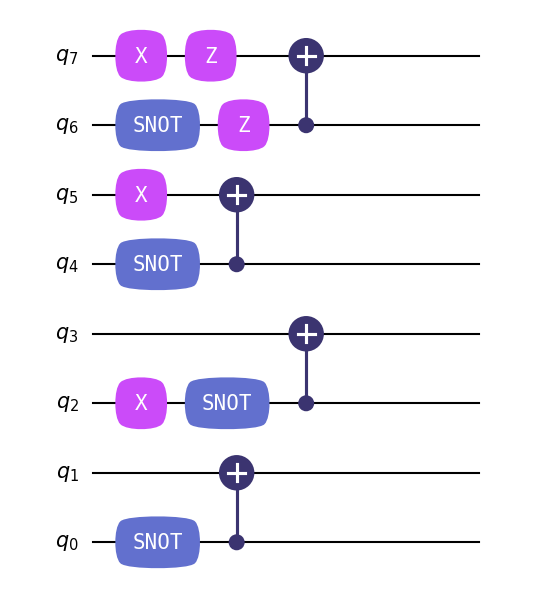

In [77]:
from qutip import tensor, basis, bell_state
from qutip_qip.circuit import QubitCircuit

qc_qutip = QubitCircuit(8)
# Create B_00 between q_0 and q_1
qc_qutip.add_gate("SNOT", 0)
qc_qutip.add_gate("CNOT", 1, 0)
# Create B_01
qc_qutip.add_gate("X", 2)
qc_qutip.add_gate("SNOT", 2)
qc_qutip.add_gate("CNOT", 3, 2)
# Create B_10
qc_qutip.add_gate("X", 5)
qc_qutip.add_gate("SNOT", 4)
qc_qutip.add_gate("CNOT", 5, 4)
# Create B_11
qc_qutip.add_gate("X", 7)
qc_qutip.add_gate("SNOT", 6)
qc_qutip.add_gate("Z", 6)
qc_qutip.add_gate("Z", 7)
qc_qutip.add_gate("CNOT", 7, 6)
qc_qutip.draw()

In [78]:
# Prepare the 8-qubit 0 state
psi = tensor([basis(2, 0) for _ in range(8)])
# Run the circuit
res = qc_qutip.run(psi)

# now we can examine the 4 subsystems (which should correspond to the 4 bell states)
# By performing a partial trace for each qubit pair.
# I have named them Bc_xx because they are *B*ell states resulting from the *c*ircuit
Bc_00 = res.ptrace([0, 1])
Bc_01 = res.ptrace([2, 3])
Bc_10 = res.ptrace([4, 5])
Bc_11 = res.ptrace([6, 7])

In [79]:
# Then, for comparison, we can grab the definitions of the Bell states from Qutip and compare
B_00 = bell_state('00')
B_01 = bell_state('01')
B_10 = bell_state('10')
B_11 = bell_state('11')
# But since the partial trace returns a density matrix, we need to convert the Bell statevectors into density matrices too for easy comparison
assert(B_00.proj() == Bc_00)
assert(B_01.proj() == Bc_01)
assert(B_10.proj() == Bc_10)
assert(B_11.proj() == Bc_11)

The asserts pass, so we have designed a circuit that creates all 4 Bell states in parallel

## Design in Qiskit

Now we need to set up the same circuit in Qiskit. We will use a sampler later on, so we will add a classical register and measurement operations

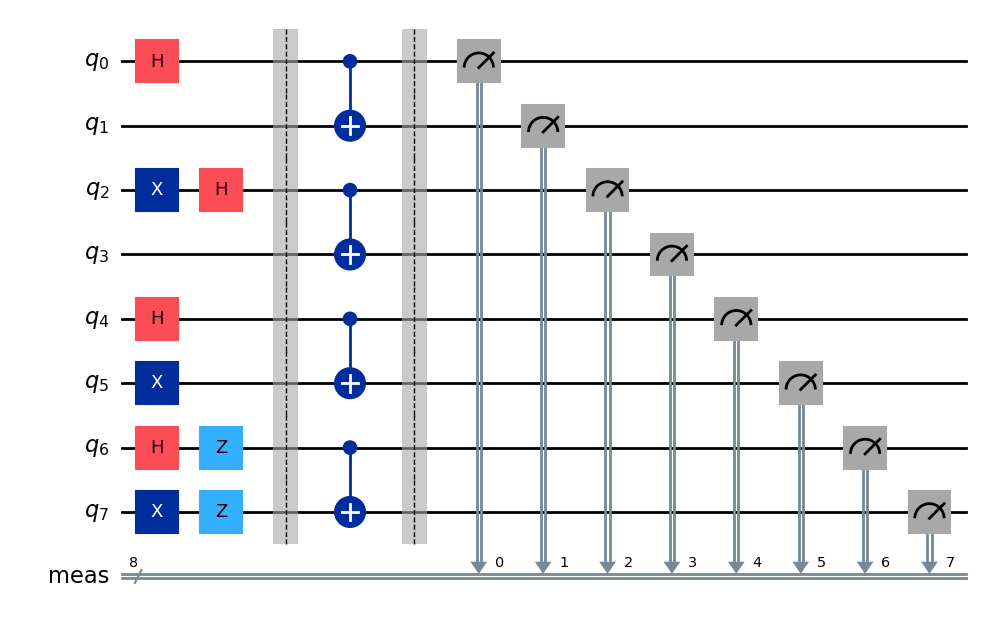

In [80]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp

qr = QuantumRegister(8, 'q')
cr = ClassicalRegister(8, 'meas') 
qc = QuantumCircuit(qr)

# B_00
qc.h(0)

# B_01
qc.x(2)
qc.h(2)

# B_10
qc.x(5)
qc.h(4)

# B_11
qc.x(7)
qc.h(6)
qc.z(6)
qc.z(7)

qc.barrier()

qc.cx(0, 1)
qc.cx(2, 3)
qc.cx(4, 5)
qc.cx(6, 7)

qc.measure_all()

qc.draw('mpl')

Though we could also export ourt circuit from QuTiP and import it into Qiskit.

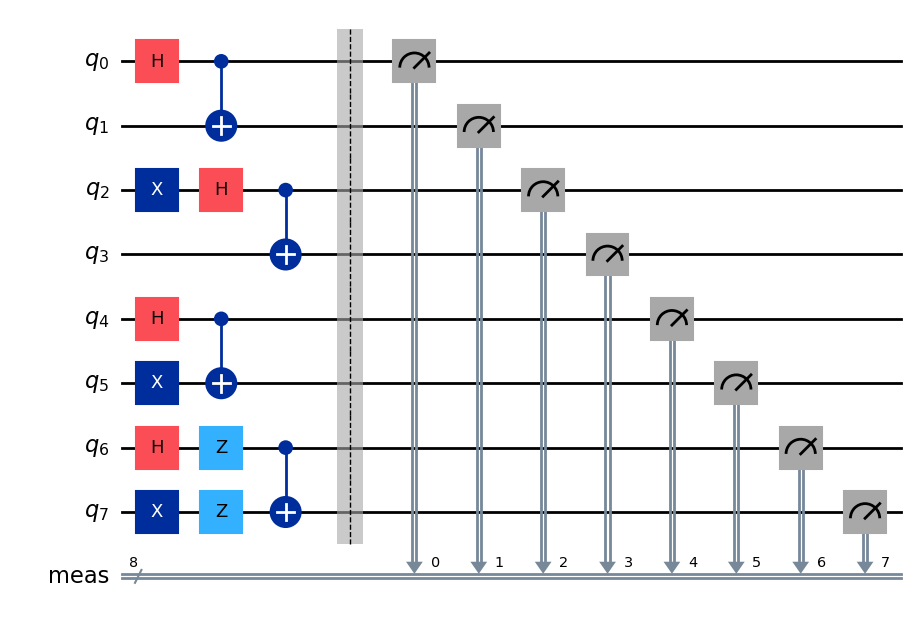

In [85]:
from qutip_qip.qasm import circuit_to_qasm_str
from qiskit.qasm2 import loads

# Build a Qasm string, this can be sotred extrenally in a file
qasm = circuit_to_qasm_str(qc_qutip)

# Load the qasm string, this can also come from a file
circuit = loads(qasm)
circuit.measure_all()
circuit.draw('mpl')